In [23]:
"""Logistic Regression"""

from re import sub
import numpy as np
import pandas as pd 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

In [24]:
"""Read features.txt and initialize feature dictionaries. Adapated from Brandon's LSTM code."""

def get_strings(data_file):
  """Process input file into a list of strings."""
  input_file = open(data_file)
  input_file.readline() # Skip first line
  UR_strings, SR_strings, syll_lengths = [], [], []
  ur_num = 0

  for line in input_file.readlines():
    columns = line.rstrip().split(",")
    if len(columns) == 2:
      ur, sr = columns
      if sr == "" or ur == "":
        continue
      ur_num += 1

      syll_lengths.append(len([seg for seg in ur.split(" ") if seg != ""]))
      UR_strings.append(ur)
      SR_strings.append(sr[-5:]) # Last 5 characters correspond to plural suffix
    else:
       print(line)
       raise Exception("Training data error! All lines should have 2 columns in TD files!")
  input_file.close()

  return UR_strings, SR_strings, syll_lengths

def get_arrays(UR_strings, SR_strings, syll_lengths, symbol2feats, suffix2label, override_max_syll=0):
  if override_max_syll:
    assert override_max_syll > max(syll_lengths)
    max_len = override_max_syll
  else: 
    max_len = max(syll_lengths)
  
  X_list = []
  Y_list = []
  padding_strs = []
  for word_index, syll_length in enumerate(syll_lengths):
    padding = " ".join(["_"]*(max_len-syll_length))
    this_ur = UR_strings[word_index]+" "+padding # Singular form + padding as string
    padding_strs.append(this_ur)
    this_sr = SR_strings[word_index][-5:] # Suffix as string

    #Fix some errors in data files:
    this_ur = sub(" J ", " Y ", this_ur)
    this_ur = sub(" C ", " CH ", this_ur)

    X_list.append([symbol2feats[seg] for seg in this_ur.split(" ") if seg != ""])
    Y_list.append(suffix2label[this_sr])

  X = np.array(X_list)
  Y = np.array(Y_list)

  return X, Y


In [25]:
"""Implements a pooling function to pool together phonetic feature vectors from different segments into a representative embedding vector."""

# Pooling function 

def pool_average(X):
    """Pools phonetic feature vectors by averaging across all segments."""
    # X.shape (n, 5, 19)
    return np.mean(X, axis=1)

def pool_sum(X):
    """Pools phonetic feature vectors by summation across all segments."""
    return np.sum(X, axis=1)

def pool_last(X):
    """Pools phonetic feature vectors by only returning the final segment."""
    last = X[:, -1, :]
    return last

def pool_concat(X):
	"""Pools features by concat each features vector head-to-tail. Results in a word-level feature vector of 5x19"""
	return np.array([np.concatenate(submatrices, axis=0) for submatrices in X])


In [26]:
"""Load training data and fit logistic regression model"""

FEATURES_FILE = "featsNew"
TRAINING_DATA_FOLDER = "MinDefault"
FILE_PREFIX = "minDefault"

# TRAINING_DATA = f"./{TRAINING_DATA_FOLDER}/{FILE_PREFIX}_train.txt"
TRAINING_DATA = f"./{TRAINING_DATA_FOLDER}/{FILE_PREFIX}_train_withIslands.txt"
POOLING_FUNC = pool_concat # TODO change pooling function

#inputs
feat_file = open(FEATURES_FILE, "r")
feat_names = feat_file.readline().rstrip().split("\t")[1:] # Skip first space
symbol2feats = {'_': [0.0 for f in feat_names]}

for line in feat_file.readlines():
  columns = line.rstrip().split("\t")
  seg = columns[0]
  values = [{"-":-1.0, "+":1.0, "0":0.0}[v] for v in columns[1:]]
  symbol2feats[seg] = values

#outputs
suffix2label = {
	"Y IY0": 0, #yee
	"W AH0": 1, #wuh
	"L EY0": 2 #lay
	}

URs, SRs, Ls = get_strings(TRAINING_DATA)
X, y = get_arrays(URs, SRs, Ls, symbol2feats, suffix2label)

X = POOLING_FUNC(X) 

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_test)

# Evaluate the model on validation split
class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        23
           1       0.99      1.00      1.00       108
           2       0.98      1.00      0.99       107

    accuracy                           0.99       238
   macro avg       0.99      0.96      0.97       238
weighted avg       0.99      0.99      0.99       238



In [27]:
def get_plot(y_test, y_pred, title):
	"""
		"Y IY0": 0, #yee blue
		"W AH0": 1, #wuh green
		"L EY0": 2 #lay pink
	"""

	label2seg = {0: "Y IY0", 1: "W AH0", 2: "L EY0"}
	data = {
		"Y IY0": {"Y IY0": 0, "W AH0": 0, "L EY0": 0},
		"W AH0": {"Y IY0": 0, "W AH0": 0, "L EY0": 0},
		"L EY0": {"Y IY0": 0, "W AH0": 0, "L EY0": 0}
	}
	for gold_label, guess_label in zip(y_test, y_pred):
		gold = label2seg[gold_label]
		guess = label2seg[guess_label]
		data[gold][guess] += 1

	df = pd.DataFrame(data)
	df = df.T
	df ['sum'] = df.sum(axis=1)
	df.sort_values('sum', ascending=False)[['Y IY0','W AH0', 'L EY0']].plot.bar(rot=0, title=title, width=1) 
	plt.xlabel("Gold Class")
	plt.ylabel("Counts grouped by Predicted Class")
	plt.show()

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        96
           1       0.98      1.00      0.99        96
           2       0.92      1.00      0.96        96

    accuracy                           0.97       288
   macro avg       0.97      0.97      0.96       288
weighted avg       0.97      0.97      0.96       288



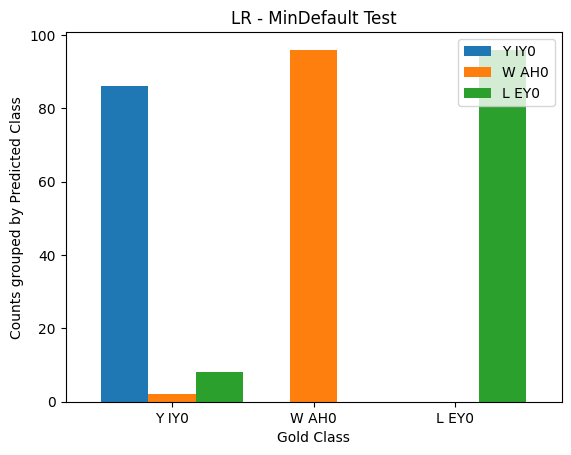

In [28]:
"""Evaluate test set"""
TEST_DATA = f"./{TRAINING_DATA_FOLDER}/{FILE_PREFIX}_test.txt"

test_SGs, test_PLs, test_Ls = get_strings(TEST_DATA)
X_test, y_test = get_arrays(test_SGs, test_PLs, test_Ls, symbol2feats, suffix2label)

X_test = POOLING_FUNC(X_test) # TODO Pool feature vectors

y_pred = model.predict(X_test)
class_report = classification_report(y_test, y_pred)
print(class_report)

get_plot(y_test, y_pred, title=f"LR - {TRAINING_DATA_FOLDER} Test")

              precision    recall  f1-score   support

           0       1.00      0.88      0.93        32
           1       0.97      1.00      0.98        32
           2       0.91      1.00      0.96        32

    accuracy                           0.96        96
   macro avg       0.96      0.96      0.96        96
weighted avg       0.96      0.96      0.96        96



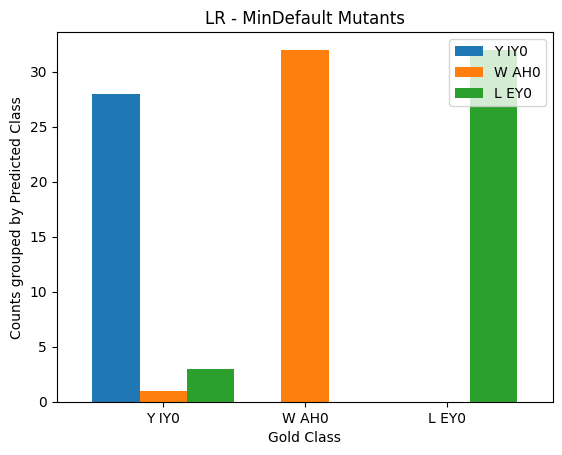

In [29]:
"""Evaluate test mutant set"""
TEST_DATA = f"./{TRAINING_DATA_FOLDER}/{FILE_PREFIX}_test_Mutants.txt"

test_SGs, test_PLs, test_Ls = get_strings(TEST_DATA)
X_test, y_test = get_arrays(test_SGs, test_PLs, test_Ls, symbol2feats, suffix2label)

X_test = POOLING_FUNC(X_test) # TODO Pool feature vectors

y_pred = model.predict(X_test)
class_report = classification_report(y_test, y_pred)
print(class_report)

get_plot(y_test, y_pred, title=f"LR - {TRAINING_DATA_FOLDER} Mutants")

              precision    recall  f1-score   support

           0       1.00      0.74      0.85        96
           1       0.00      0.00      0.00         0

    accuracy                           0.74        96
   macro avg       0.50      0.37      0.43        96
weighted avg       1.00      0.74      0.85        96



/home/tniu/miniconda3/envs/llm-base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tniu/miniconda3/envs/llm-base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tniu/miniconda3/envs/llm-base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

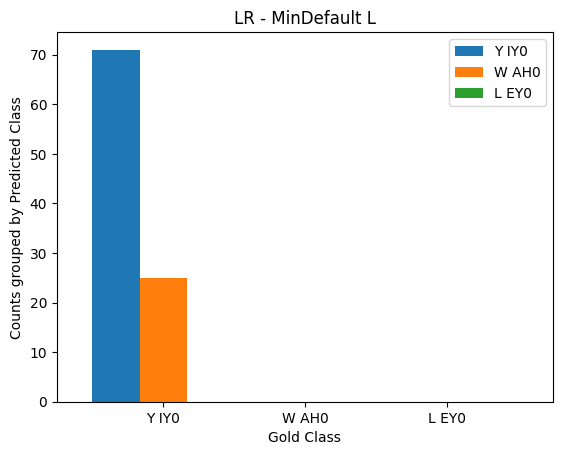

In [30]:
"""Evaluate test liquids set"""
TEST_DATA = f"./{TRAINING_DATA_FOLDER}/{FILE_PREFIX}_test_L.txt"

test_SGs, test_PLs, test_Ls = get_strings(TEST_DATA)
X_test, y_test = get_arrays(test_SGs, test_PLs, test_Ls, symbol2feats, suffix2label)

X_test = POOLING_FUNC(X_test) # TODO Pool feature vectors

y_pred = model.predict(X_test)
class_report = classification_report(y_test, y_pred)
print(class_report)

get_plot(y_test, y_pred, title=f"LR - {TRAINING_DATA_FOLDER} L")

              precision    recall  f1-score   support

           0       0.59      0.95      0.73        60
           1       0.86      0.47      0.61        40
           2       0.91      0.50      0.65        40

    accuracy                           0.69       140
   macro avg       0.79      0.64      0.66       140
weighted avg       0.76      0.69      0.67       140



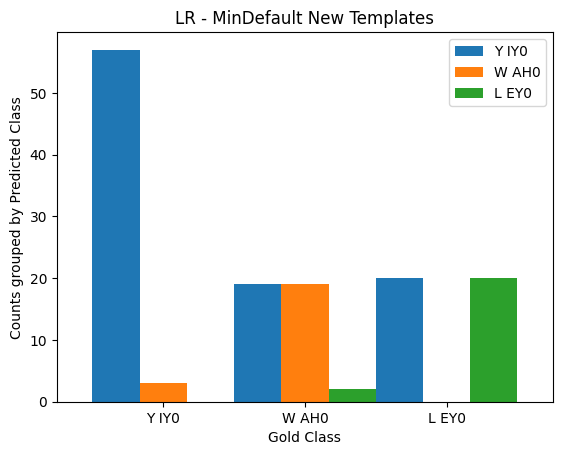

In [31]:
"""Evaluate test new templates set"""
TEST_DATA = f"./{TRAINING_DATA_FOLDER}/{FILE_PREFIX}_testNewTemplates.txt"

test_SGs, test_PLs, test_Ls = get_strings(TEST_DATA)
X_test, y_test = get_arrays(test_SGs, test_PLs, test_Ls, symbol2feats, suffix2label, override_max_syll=5)

X_test = POOLING_FUNC(X_test) # TODO Pool feature vectors

y_pred = model.predict(X_test)
class_report = classification_report(y_test, y_pred)
print(class_report)

get_plot(y_test, y_pred, title=f"LR - {TRAINING_DATA_FOLDER} New Templates")

/home/tniu/miniconda3/envs/llm-base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tniu/miniconda3/envs/llm-base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tniu/miniconda3/envs/llm-base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      40.0
           2       0.00      0.00      0.00       0.0

    accuracy                           0.00      40.0
   macro avg       0.00      0.00      0.00      40.0
weighted avg       0.00      0.00      0.00      40.0



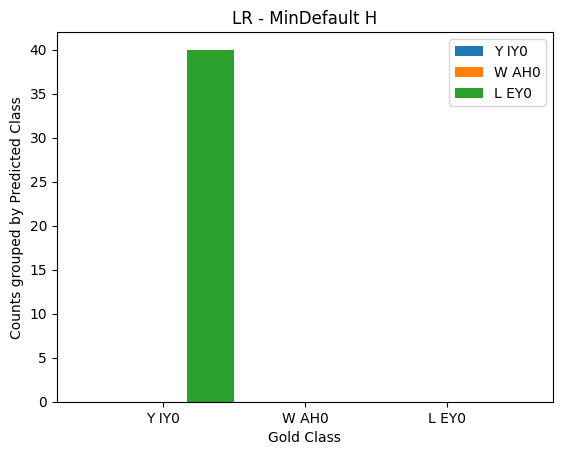

In [32]:
"""Evaluate test H set"""
TEST_DATA = f"./{TRAINING_DATA_FOLDER}/{FILE_PREFIX}_test_H.txt"

test_SGs, test_PLs, test_Ls = get_strings(TEST_DATA)
X_test, y_test = get_arrays(test_SGs, test_PLs, test_Ls, symbol2feats, suffix2label)

X_test = POOLING_FUNC(X_test) # TODO Pool feature vectors

y_pred = model.predict(X_test)
class_report = classification_report(y_test, y_pred)
print(class_report)

get_plot(y_test, y_pred, title=f"LR - {TRAINING_DATA_FOLDER} H")